In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

In [3]:
plant = pd.read_csv('../../data/ad.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['smiles'])

plant_features_maccs = featurizer.featurize(plant['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
data_maccs_mask = vt.get_support(indices=True)
plant_maccs_features = plant_features_maccs[:, data_maccs_mask]

dataset = dc.data.NumpyDataset(X_new,data['class'])

In [6]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

# GridSearchCV

In [7]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
}


param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100], 
              'kernel': ['linear', 'rbf','poly'],
             'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.8, 0.9, 1]
             }
    
svm_classifier = SVC(probability=True)

gs = GridSearchCV(
                    svm_classifier,
                   param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=100),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_dataset.y.ravel())

In [8]:
val_AUC = gs.best_score_
val_ACC = gs.cv_results_['mean_test_ACC'][gs.best_index_]
val_PRE = gs.cv_results_['mean_test_PRE'][gs.best_index_]
val_REC = gs.cv_results_['mean_test_REC'][gs.best_index_]

# GridSearchCV_Result

In [9]:
print('Best parameters: ', gs.best_params_)
print('Best score (AUC): ', gs.best_score_)
print('ACC: ',gs.cv_results_['mean_test_ACC'][gs.best_index_])
print('PRE: ',gs.cv_results_['mean_test_PRE'][gs.best_index_])
print('REC: ',gs.cv_results_['mean_test_REC'][gs.best_index_])

Best parameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score (AUC):  0.9430019892758701
ACC:  0.8743589743589743
PRE:  0.8656077256077255
REC:  0.8866397258502522


In [10]:
model = gs_fit.best_estimator_
model

SVC(C=1, gamma=0.1, probability=True)

In [12]:
pred_proba = model.predict_proba(plant_maccs_features)

In [13]:
test_pred_list = []
for test_score in pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [14]:
test_pred_array = np.array(test_pred_list)

In [15]:
test_pred_array

array([0.97609686, 0.98421996, 0.9707237 , ..., 0.91118105, 0.87603756,
       0.9704716 ])

In [16]:
df = pd.DataFrame({
    'Scientific_name':plant['Scientific_name'],
    'Chinese_name':plant['Chinese_name'],
    'Volatile_compounds':plant['Volatile_compounds'],
    'Compound_content':plant['Compound_content'],
    'Analysis_method':plant['Analysis_method'],
    'Cite':plant['Cite'],
    'SMILES':plant['smiles'],
    'pred':test_pred_array
})

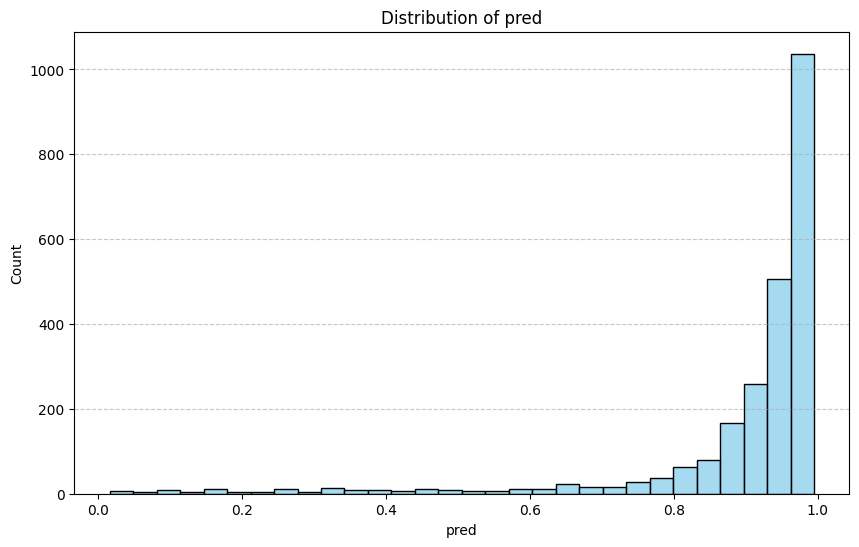

In [17]:
import seaborn as sns

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.histplot(df['pred'], bins=30, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of pred')
plt.xlabel('pred')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
count_above_0_5 = df[df['pred'] >= 0.5].shape[0]
count_above_0_9 = df[df['pred'] >= 0.9].shape[0]
count_above_0_95 = df[df['pred'] >= 0.95].shape[0]

# 输出结果
print(f"概率在 0.5 以上的数量: {count_above_0_5}")
print(f"概率在 0.9 以上的数量: {count_above_0_9}")
print(f"概率在 0.95 以上的数量: {count_above_0_95}")

概率在 0.5 以上的数量: 2266
概率在 0.9 以上的数量: 1790
概率在 0.95 以上的数量: 1286


# Evaluate model

In [18]:
y_test_pred_proba = model.predict_proba(test_dataset.X)
y_test_pred = model.predict(test_dataset.X)

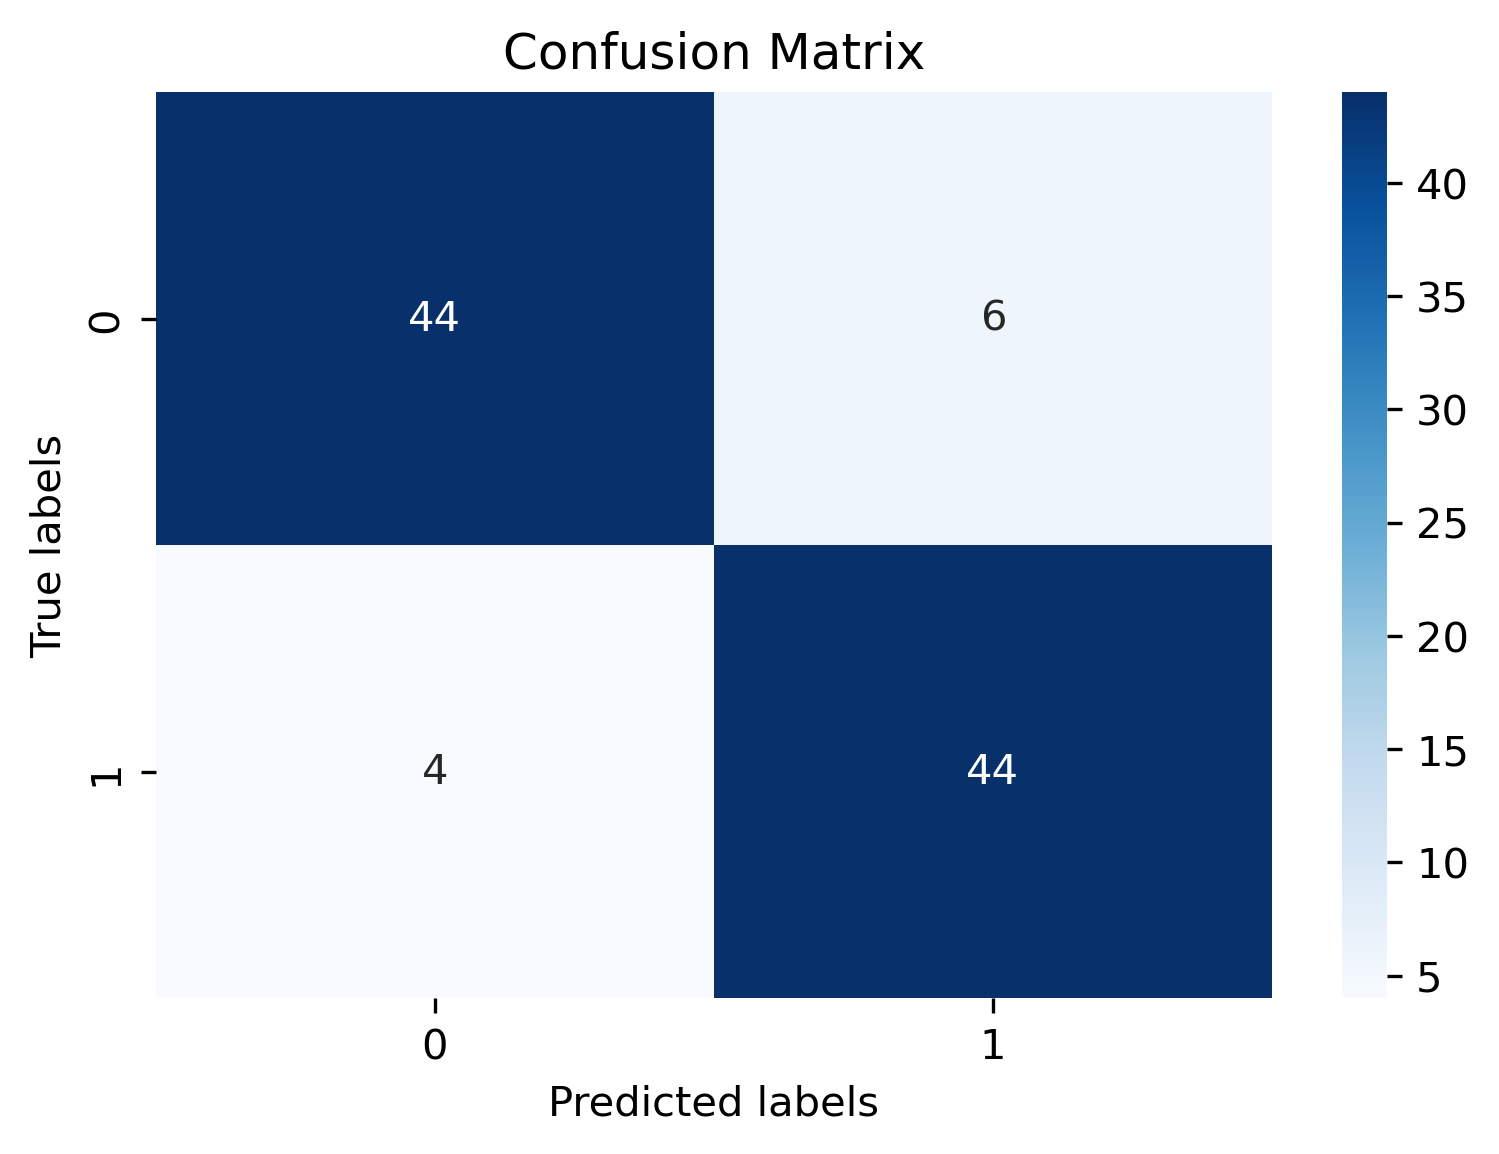

In [19]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [20]:
test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [21]:
test_pred_array = np.array(test_pred_list)

In [22]:
test_AUC = roc_auc_score(test_dataset.y,test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(test_pred_array))

# Finall result

In [23]:
performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [24]:
performance = pd.DataFrame(performance_dataset,index=['val','test'])
performance

,AUC,ACC,PRE,REC
val,0.94287,0.874359,0.865608,0.886640
test,0.98375,0.897959,0.880000,0.916667
